In [38]:
# Librerias utilizadas
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.callbacks import EarlyStopping

# Importación de datos

In [39]:
df = pd.read_csv('data/DATA_36.85_-4.24.csv')
df.head()

,DATA,spdi_1,spdi_3,spdi_6,spdi_9,spdi_12,spdi_24,spdi_36,spdi_48,spei_1,...,spi_6,spi_9,spi_12,spi_24,spi_36,spi_48,scpdsi,scphdi,sczindex,scwplm
0,1961-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,-0.08,-0.08,-0.57,-0.08
1,1961-01-09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,-0.20,-0.20,-0.90,-0.20
2,1961-01-16,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,-0.25,-0.25,-0.39,-0.25
3,1961-01-23,-0.59,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.47,...,NaN,NaN,NaN,NaN,NaN,NaN,-0.35,-0.35,-0.80,-0.35
4,1961-02-01,-0.83,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.79,...,NaN,NaN,NaN,NaN,NaN,NaN,-0.47,-0.47,-0.88,-0.47


# Preprocesamiento de datos

In [40]:
# Creamos un dataset del indice SPI para un periodo de 1 mes
spi_1 = df['spi_1']
# Quitamos valores vacios
spi_1 = spi_1.dropna(how='all')
# Comprobamos que los únicos valores vacíos eran los iniciales
print(len(spi_1))
print(spi_1.index[-1]-spi_1.index[0]+1)
spi_1.head()

2925
2925


3   -0.50
4   -0.77
5   -0.87
6   -1.36
7   -1.73
Name: spi_1, dtype: float64

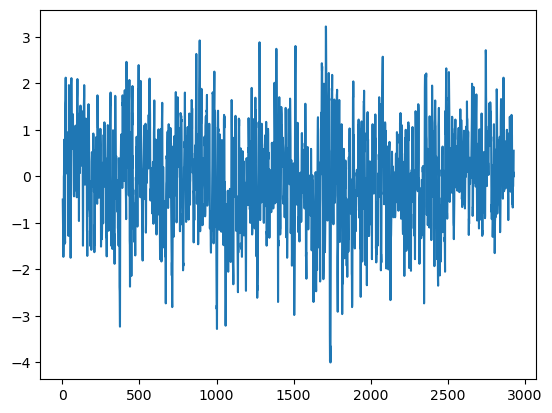

In [41]:
spi_1.plot()
plt.show()

In [42]:
# Separación en conjunto de entrenamiento y de prueba
train_df, test_df = train_test_split(spi_1, test_size=0.13, shuffle=False)

In [43]:
# Creamos un dataset sequencial con arrays de valores input/output
# Este dataset tiene la estructura adecuada para los datos de entrada
# en la red neuronal
def to_sequences(seq_size, obs):
    x = []
    y = []

    for i in range(len(obs)-seq_size):
        window = obs.iloc[i:(i+seq_size)]
        after_window = obs.iloc[i+seq_size]
        window = [[x] for x in window]
        x.append(window)
        y.append(after_window)
        
    return np.array(x),np.array(y)
    
    
sequence_size = 10
X_train,y_train = to_sequences(sequence_size, train_df)
X_test,y_test = to_sequences(sequence_size, test_df)

print("Dimensiones del training set: {}".format(X_train.shape))
print("Dimensiones del test set: {}".format(X_test.shape))

Dimensiones del training set: (2534, 10, 1)
Dimensiones del test set: (371, 10, 1)


# Definición del modelo

In [52]:
model = Sequential()
model.add(LSTM(15, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dense(1))

# Compilación del modelo

In [53]:
model.compile(optimizer='adam', loss='mse')

# Entrenamiento del modelo

In [54]:
# Creamos un early stopping para evitar overfitting
es = EarlyStopping(monitor='val_loss', verbose=1, patience=3)

In [55]:
history = model.fit(X_train, y_train, epochs=200, batch_size=10, validation_data=(X_test, y_test), verbose=2, shuffle=False, callbacks=[es])

Epoch 1/200
254/254 - 2s - loss: 0.7141 - val_loss: 0.3617 - 2s/epoch - 8ms/step
Epoch 2/200
254/254 - 1s - loss: 0.4772 - val_loss: 0.2477 - 813ms/epoch - 3ms/step
Epoch 3/200
254/254 - 1s - loss: 0.3788 - val_loss: 0.2144 - 889ms/epoch - 3ms/step
Epoch 4/200
254/254 - 1s - loss: 0.3609 - val_loss: 0.2113 - 944ms/epoch - 4ms/step
Epoch 5/200
254/254 - 1s - loss: 0.3577 - val_loss: 0.2104 - 861ms/epoch - 3ms/step
Epoch 6/200
254/254 - 1s - loss: 0.3561 - val_loss: 0.2099 - 808ms/epoch - 3ms/step
Epoch 7/200
254/254 - 1s - loss: 0.3549 - val_loss: 0.2096 - 860ms/epoch - 3ms/step
Epoch 8/200
254/254 - 1s - loss: 0.3538 - val_loss: 0.2093 - 851ms/epoch - 3ms/step
Epoch 9/200
254/254 - 1s - loss: 0.3528 - val_loss: 0.2090 - 835ms/epoch - 3ms/step
Epoch 10/200
254/254 - 1s - loss: 0.3519 - val_loss: 0.2087 - 832ms/epoch - 3ms/step
Epoch 11/200
254/254 - 1s - loss: 0.3509 - val_loss: 0.2083 - 848ms/epoch - 3ms/step
Epoch 12/200
254/254 - 1s - loss: 0.3498 - val_loss: 0.2081 - 829ms/epoch - 3

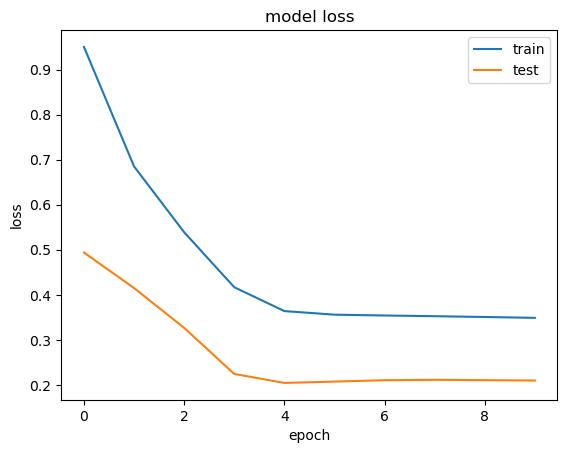

In [48]:
# Resumen del entrenamiento
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

# Evaluación del modelo

In [56]:
train_prediction = model.predict(X_train)
test_prediction = model.predict(X_test)
train_score = model.evaluate(X_train, y_train)
test_score = model.evaluate(X_test, y_test)
print('Train score: {} MSE'.format(train_score))
print('Test score: {} MSE'.format(test_score))

12/12 [==============================] - 0s 1ms/step - loss: 0.1947
Train score: 0.29717493057250977 MSE
Test score: 0.1947406828403473 MSE


# Visualización de la predicción

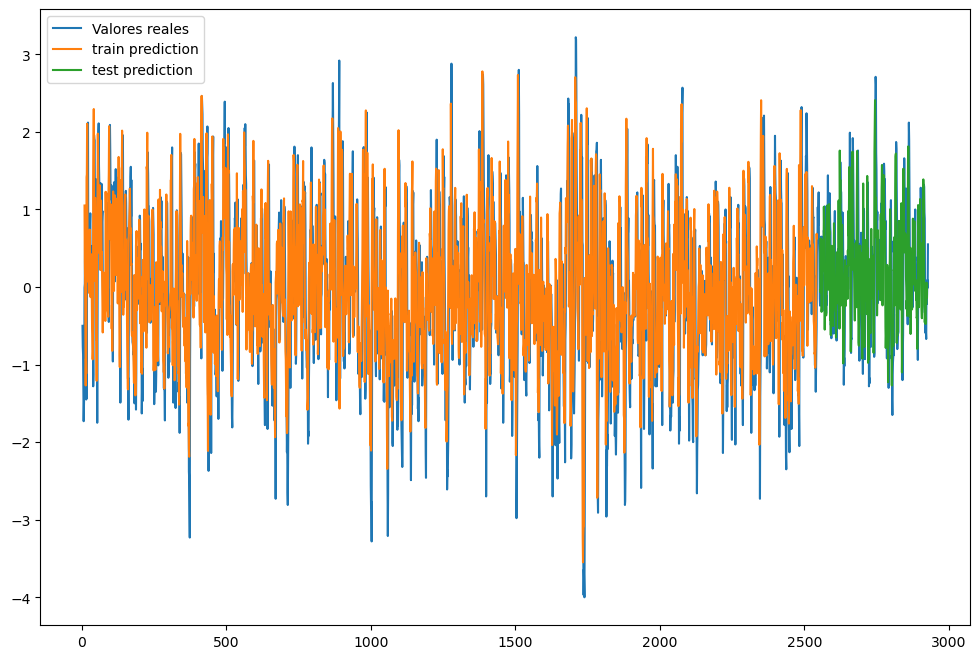

In [57]:
# Graficamos los valores reales frente a los datos de predicción
plt.figure(figsize=(12, 8))
train_stamp = np.arange(sequence_size, sequence_size + X_train.shape[0])
test_stamp = np.arange(2 * sequence_size + X_train.shape[0], len(spi_1))
plt.plot(spi_1, label='Valores reales')
plt.plot(train_stamp, train_prediction, label='train prediction')
plt.plot(test_stamp, test_prediction, label = 'test prediction')
plt.legend()
plt.show()